整理自 ：https://github.com/ZhiqingXiao/rl-book/blob/master/en2024/code/CartPole-v0_VPG_torch.ipynb

In [ ]:
!pip install gymnasium

In [ ]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.INFO,
          format='%(asctime)s [%(levelname)s]%(message)s',
          stream=sys.stdout, datefmt='%H；%M:%S')

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

## 环境


* https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='rgb_array')  # 奖励阈值 500
print(env.action_space.n) # 动作数

2


## 算法 模块

In [ ]:
class REINFORCEAgent:
  def __init__(self, env):
    self.action_n = env.action_space.n
    self.gamma = 0.99 # 折扣因子

    self.policy_net = self.build_net(
        input_size = env.observation_space.shape[0],
        hidden_sizes = [],
        output_size = self.action_n, output_activator=nn.Softmax(1))  # nn.Softmax(dim=None)： dim=0表示对列进行归一化，dim=1表示对行进行归一化
    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.005)

  def build_net(self, input_size, hidden_sizes, output_size,
          output_activator=None, use_bias=False):
    layers = []
    for input_size, output_size in zip([input_size,]+hidden_sizes, hidden_sizes+[output_size,]):
      layers.append(nn.Linear(input_size, output_size, bias=use_bias))
      layers.append(nn.ReLU())
    layers = layers[:-1]
    if output_activator:
      layers.append(output_activator)
    model = nn.Sequential(*layers)
    return model

  def reset(self, mode=None):
    self.mode = mode
    if self.mode == "train":
      self.trajectory = []

  def step(self, observation, reward, terminated):
    state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
    prob_tensor = self.policy_net(state_tensor)  #
    action = distributions.Categorical(prob_tensor).sample().item()
    if self.mode == "train":  # 训练状态进行采样， 测试时直接返回动作 即可
      self.trajectory += [observation, reward, terminated, action]
    return action

  def close(self):
    if self.mode == "train":
      self.learn()

  def learn(self):  # 学习 模块
    state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
    reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
    action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
    arange_tensor = torch.arange(state_tensor.shape[0],dtype=torch.float)
    discount_tensor = self.gamma ** arange_tensor
    discounted_reward_tensor = discount_tensor * reward_tensor
    discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
    all_pi_tensor = self.policy_net(state_tensor)
    pi_tensor = torch.gather(all_pi_tensor, 1, action_tensor.unsqueeze(1)).squeeze(1)
    log_pi_tensor = torch.log(torch.clamp(pi_tensor, 1e-6, 1,))  # torch.clamp 将输入张量的元素限制在指定范围内
    loss_tensor = -(discounted_return_tensor * log_pi_tensor).mean() #
    self.optimizer.zero_grad() # 重置 梯度
    loss_tensor.backward() # 反向传播
    self.optimizer.step() # 更新权重

agent = REINFORCEAgent(env)

## 训练

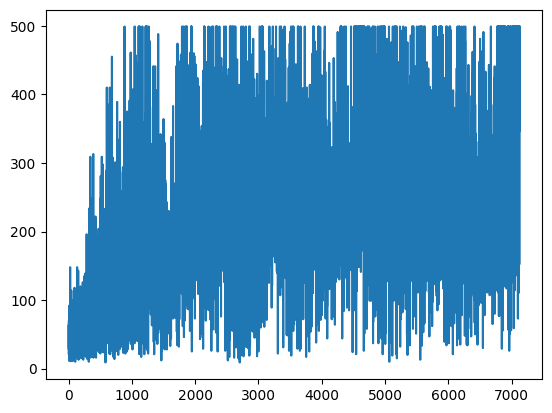

In [ ]:
def play_episode(env, agent, seed=None, mode=None, render=False):
  observation, _ = env.reset(seed=seed)
  reward, terminated, truncated = 0., False, False
  agent.reset(mode=mode)
  episode_reward, elapsed_steps = 0., 0
  while True:
    action = agent.step(observation, reward, terminated)
    observation, reward, terminated, truncated, info = env.step(action)
    if render:
      env.render()
    if terminated or truncated:
      break
    episode_reward += reward
    elapsed_steps += 1 # 走过的步数
  agent.close()

  return episode_reward, elapsed_steps

logging.info("===== train =====")
episode_rewards = []
for episode in itertools.count(): # 从 0 到无穷大的 迭代次数
  episode_reward, elapsed_steps = play_episode(env, agent, seed=episode, mode="train")
  episode_rewards.append(episode_reward)
  logging.info('train episode %d：reward = %.2f, steps = %d',
               episode, episode_reward, elapsed_steps)
  if np.mean(episode_rewards[-20:]) > 400: #  刚开始跑，可考虑将值设得小些
    break

plt.plot(episode_rewards)


logging.info("===== test =====")
episode_rewards_test = []
for episode in range(100):
  epsiode_reward, elapsed_steps = play_episode(env, agent)
  episode_rewards_test.append(episode_reward)
  logging.info('test episode % d: reward = %.2f, steps=%d',
        episode, episode_reward, elapsed_steps)
logging.info("average episode reward = %.2f ± %.2f",
       np.mean(episode_rewards_test), np.std(episode_rewards_test))

env.close()

<font size=5, color=red>**从图可以看出，有不少回合都达到了奖励阈值 500。 但很不稳定，这是 方差大 造成的**</font>

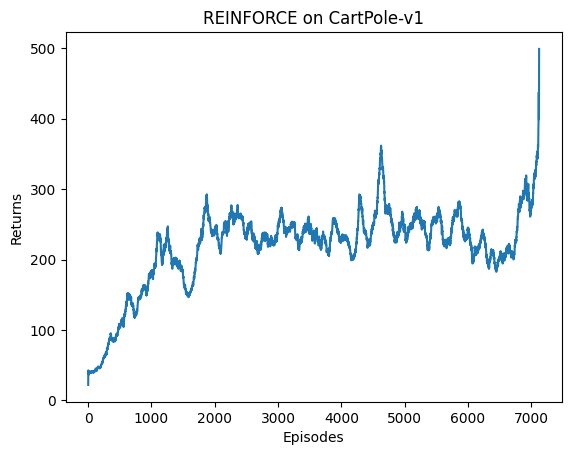

In [ ]:
# 平滑

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

episodes_list = list(range(len(episode_rewards)))  # x
mv_return = moving_average(episode_rewards, 69)  # 9 可考虑改大些，让图好看些
plt.plot(episodes_list, mv_return)  # x y
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()